<a href="https://colab.research.google.com/github/aleschiavo94/Convolutional-Neural-Network-for-Medical-Imaging-Analysis---Abnormality-detection-in-mammography/blob/main/Scratch_CNN_benign_vs_malign.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Scratch CNN**
---
Classification model for discriminating between 2 classes: **benign vs malign samples**. *Ad-hoc CNN architecture*.

**Students:**   *A. Schiavo - M. Gómez - M. Daole*



##1.Project Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True) 

Mounted at /content/gdrive


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import itertools
import numpy as np
import pandas as pd 
import ast #Abstract Syntax Trees
import os 
import gc # Garbage Collector

from tensorflow.keras import backend as K # Useful to free GPU and memory
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from keras import layers, optimizers, models, regularizers, metrics
from keras.models import load_model
#ROC-AUC 
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from keras.wrappers.scikit_learn import KerasClassifier

#print confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import matplotlib.pyplot as plt

BATCH_SIZE = 20
EPOCHS = 100
IMAGE_HEIGHT = 150
IMAGE_WIDTH = 150

base_path = "/content/gdrive/My Drive/Colab_Notebooks/CIDL/DL Project"
PLOTS_PATH =  os.path.join(base_path, 'plots/Benign-Malign')
train_img_path = os.path.join(base_path, 'numpy data/train_tensor.npy')
train_label_path = os.path.join(base_path, 'numpy data/train_labels.npy')
test_img_path = os.path.join(base_path, 'numpy data/public_test_tensor.npy')
test_label_path = os.path.join(base_path, 'numpy data/public_test_labels.npy')

MODEL_PATH = os.path.join(base_path, "models/Benign-Malign")

# to produce final model report histogram 
AUC_values = []
TPR_values = []
FPR_values = []
PRECISION_values = []
SPECIFICITY_values = []

print("Done")

Done


In [ ]:
# Custom Callback To Include in Callbacks List At Training Time
class GarbageCollectorCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
      gc.collect()

print("Done")

Done


##2.Utility Functions

In [ ]:
# ----------------------- Utility Functions -----------------------
def load_training():
  train_images = np.load(train_img_path)
  train_labels = np.load(train_label_path)
  test_images = np.load(test_img_path)
  test_labels = np.load(test_label_path)

  return train_images, train_labels, test_images, test_labels

# Remove baseline samples
def remove_baseline(tensor): 
  max_ind = int(len(tensor)/2)
  indexes = [2*i + 1 for i in range(0, max_ind)]

  return tensor[indexes]

# Interchange the dataset index
def shuffle_dataset(x, y):
  indices = tf.range(start=0, limit=tf.shape(x)[0], dtype=tf.int32)
  shuffled_indices = tf.random.shuffle(indices)

  x = tf.gather(x, shuffled_indices)
  y = tf.gather(y, shuffled_indices)

  x = x.numpy()
  y = y.numpy()

  return x, y

# split dataset into training and validation set 70-30
def split_train_val(dataset, labels):
  train_data_split = dataset[:int(0.7*len(dataset))]
  valid_data_split = dataset[int(0.7*len(dataset)):]
  train_labels_split = labels[:int(0.7*len(labels))]
  valid_labels_split = labels[int(0.7*len(labels)):]

  print(train_data_split.shape)
  print(valid_data_split.shape)
  print(train_labels_split.shape)
  print(valid_labels_split.shape)      

  return train_data_split, valid_data_split, train_labels_split, valid_labels_split

# Unify benign and malign cases 
def labels_mapping(labels):
  labels_local = np.zeros(shape=labels.shape, dtype="float32")
  idx = 0
  for label in labels:
    # benign
    if label == 1 or label == 3:
      labels_local[idx] = 0
    # malign
    else:
      labels_local[idx] = 1
    idx += 1

  return labels_local

print("Done")

def get_model_predictions(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

    #np.where(predictions < 0.5, 0, 1)
    #predictions = np.where(predictions < 0.5, 0, 1)

  return predictions


def get_model_pred_prob(model, dataset, labels, sample_count): 
  predictions = np.zeros((sample_count,))   

  BATCH_SIZE = 1
  i = 0
  for batch, labels_batch in test_datagen.flow(dataset, labels, batch_size=BATCH_SIZE, shuffle=False):
    predictions[i * BATCH_SIZE : (i + 1) * BATCH_SIZE] = model.predict_classes(batch)
    i += 1

    if i * BATCH_SIZE  >= sample_count:
      break

  return predictions

# Function to calculate True Positive Rate and False Positive Rate
def calc_TP_FP_rate(y_true, y_pred):    
    # Instantiate counters
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    # Determine whether each prediction is TP, FP, TN, or FN
    for i in range(len(y_true)): 
        if y_true[i]==y_pred[i]==1.:
           TP += 1
        if y_pred[i]==1. and y_true[i]!=y_pred[i]:
           FP += 1
        if y_true[i]==y_pred[i]==0.:
           TN += 1
        if y_pred[i]==0. and y_true[i]!=y_pred[i]:
           FN += 1
    
    print("TP: ", TP)
    print("FP: ", FP)
    print("TN: ", TN)
    print("FN: ", FN)
    
    #Precision = TP/(TP+FP)
      #Precision answers the following: How many of those who we labeled as diabetic are actually diabetic?
    precision = TP / (TP + FP)

    #Recall/Sensitivity/TPR = TP/(TP+FN)
        #Recall answers the following question: Of all the people who are diabetic, how many of those we correctly predict?
    tpr = TP / (TP + FN)

    #Specificity = TN/(TN+FP)
        #Specifity answers the following question: Of all the people who are healthy, how many of those did we correctly predict?
    specificity = TN / (TN + FP)

    #FPR  = 1 - Specificity =  FP/FP+TN
    fpr = FP / (FP + TN)

    return tpr, fpr, precision, specificity

Done


In [ ]:
# Visualization Data Histogram
def plot_acc(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  return plt

def plot_loss(history):
  acc = history.history['acc']
  val_acc = history.history['val_acc']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.figure()
  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  return plt


def plot_confusion_matrix(model,
                          classes,
                          dataset, 
                          labels,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    Y_pred = model.predict(test_datagen.flow(dataset,
                                            labels,
                                            batch_size=21,
                                            shuffle=False),
                          steps=len(dataset) // BATCH_SIZE)

    np.where(Y_pred < 0.5, 0, 1)
    y_pred = np.where(Y_pred < 0.5, 0, 1)

    print('Confusion Matrix')
    cm = confusion_matrix(labels, y_pred)

    #print(cm)
    #print('Classification Report')
    print(classification_report(labels, y_pred))


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    #print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    return plt

# Visualization Detail Metric
def plot_metrics(history):
  metrics = ['loss', 'auc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.plot(history.epoch, history.history[metric], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)

    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()
    if metrics[-1] != metric:
      plt.figure()

  return plt, cm

def plot_AUC(model, dataset, labels):
  y_pred_keras = get_model_predictions(model, dataset, labels, len(dataset))
  fpr_keras, tpr_keras, thresholds_keras = roc_curve(labels, y_pred_keras)
  #thresholds_keras = np.linspace(0,1,num=100)
  auc_keras = auc(fpr_keras, tpr_keras)

  plt.figure(1)
  plt.plot([0, 1], [0, 1], 'k--')
  plt.plot(fpr_keras, tpr_keras, label='CNN (area = {:.3f})'.format(auc_keras))
  plt.xlabel('False positive rate')
  plt.ylabel('True positive rate')
  plt.title('ROC curve')
  plt.legend(loc='best')
  #plt.show()

  return auc_keras, plt
print("Done")

Done


##3.Data Loading & Preprocessing

Currently, our data sits on a drive as numpy files (**.npy**), so the steps for getting it into our network are roughly:



In [ ]:
# Get images and labels (test, train)
train_images, train_labels, test_images, test_labels = load_training()

# Get abnormalities only 
train_images = remove_baseline(train_images)
train_labels = remove_baseline(train_labels)
test_images = remove_baseline(test_images)
test_labels = remove_baseline(test_labels)

# Suffle index (Previous dataset is ordered)
train_images, train_labels = shuffle_dataset(train_images, train_labels)

print("Train shape: ", train_images.shape)
print("Test shape: ", test_images.shape)


Train shape:  (2676, 150, 150)
Test shape:  (336, 150, 150)


In [ ]:
#1: Mass, benign
#2: Mass, malignant
#3: Calcification, benign
#4: Calcification, malignant

#count #of masses and #of calcifications
unique, counts = np.unique(train_labels, return_counts=True)
#print(unique, counts)

print("Benign Masses samples: \t", counts[0])
print("Malign Masses samples: \t", counts[1])
print("Benign Calc samples: \t", counts[2])
print("Malign Calc samples: \t", counts[3])

Benign Masses samples: 	 620
Malign Masses samples: 	 598
Benign Calc samples: 	 948
Malign Calc samples: 	 510


In [ ]:
train_labels = labels_mapping(train_labels)
test_labels = labels_mapping(test_labels)

#check if training dataset is balanced  
unique, counts = np.unique(train_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])
print()

train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
print(train_images.shape)
print(test_images.shape)

Benign samples:  1568
Malign samples:  1108

(2676, 150, 150, 1)
(336, 150, 150, 1)


In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)                                  

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./65535
train_datagen = ImageDataGenerator(rescale=1./65535)
valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

for batch, labels_batch in train_datagen.flow(train_images, train_labels, batch_size=BATCH_SIZE):
  print(batch.shape)
  print(labels_batch.shape)
  break



(20, 150, 150, 1)
(20,)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#all-in-one data loading & preprocessing function 
def init_data():
  # Get images and labels (test, train)
  train_images, train_labels, test_images, test_labels = load_training()

  # Get abnormalities only 
  train_images = remove_baseline(train_images)
  train_labels = remove_baseline(train_labels)
  test_images = remove_baseline(test_images)
  test_labels = remove_baseline(test_labels)

  # Suffle index (Previous dataset is ordered)
  train_images, train_labels = shuffle_dataset(train_images, train_labels)

  #print("Train shape: ", train_images.shape)
  #print("Test shape: ", test_images.shape)

  #1: Mass, benign
  #2: Mass, malignant
  #3: Calcification, benign
  #4: Calcification, malignant

  #count #of masses and #of calcifications
  #unique, counts = np.unique(train_labels, return_counts=True)
  #print(unique, counts)

  #print("Benign Masses samples: \t", counts[0])
  #print("Malign Masses samples: \t", counts[1])
  #print("Benign Calc samples: \t", counts[2])
  #print("Malign Calc samples: \t", counts[3])

  #labels remapping
  train_labels = labels_mapping(train_labels)
  test_labels = labels_mapping(test_labels)

  #tensors reshaping for models training 
  train_images = train_images.reshape(train_images.shape + (1,)) #(2676, 150, 150, 1)
  test_images = test_images.reshape(test_images.shape + (1,)) #(2676, 150, 150, 1)
  #print(train_images.shape)
  #print(test_images.shape)

  # split dataset into training and validation set 70-30
  train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(train_images, train_labels)  

  # All images will be rescaled by 1./65535
  train_datagen = ImageDataGenerator(rescale=1./65535)
  valid_datagen = ImageDataGenerator(rescale=1./65535)
  test_datagen = ImageDataGenerator(rescale=1./65535) 

  print("Done")
  return train_images_split, valid_images_split, train_labels_split, valid_labels_split

##4.Defining CNN 


In [ ]:
METRICS = [
      metrics.BinaryAccuracy(name='acc'),
      #metrics.Precision(name='malign_precision'),
      #metrics.Recall(name='malign_recall'),
      #metrics.AUC(name='auc'),
      #metrics.TruePositives(name= "TP"),
      #metrics.TrueNegatives(name= "TN")
]

es = tf.keras.callbacks.EarlyStopping(
     monitor='val_acc', patience=40, verbose=0,
     mode='auto', restore_best_weights=True
)

checkpoint_filepath =  os.path.join(base_path, 'models/Benign-Malign/best weights dummy')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_acc',
    mode='max',
    save_best_only=True)

def build_model(loss_function, eval_metric=METRICS):
  model = models.Sequential()
  model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(layers.MaxPooling2D((2, 2)))
  model.add(layers.Flatten())
  model.add(layers.Dense(512, activation='relu'))
  #model.add(layers.Dropout(0.5))
  #model.add(layers.Dense(512, kernel_regularizer=regularizers.l2(0.001), activation="relu"))
  model.add(layers.Dense(1, activation='sigmoid'))

  model.compile(loss=loss_function,
              optimizer=optimizers.Adam(lr=1e-4), # lr = 0.0001
              metrics=METRICS) 
  
  return model 

print("Done")

Done


##5.CNN Compilation: Baseline Model



Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

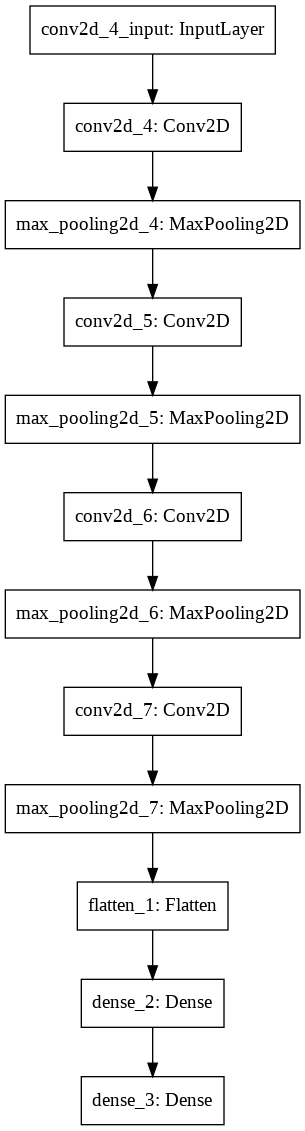

In [ ]:
from keras import optimizers 

model_0 = build_model("binary_crossentropy", "acc")

model_0.summary()
#tf.keras.utils.plot_model(model_0)

In [ ]:
history = model_0.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[es, model_checkpoint_callback])


Epoch 1/100
93/93 [==============================] - 3s 22ms/step - loss: 0.6938 - acc: 0.5461 - val_loss: 0.6828 - val_acc: 0.5863
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6814 - acc: 0.5982 - val_loss: 0.6811 - val_acc: 0.5863
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6792 - acc: 0.5819 - val_loss: 0.6794 - val_acc: 0.5838
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.6730 - acc: 0.6086 - val_loss: 0.6605 - val_acc: 0.6288
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6601 - acc: 0.6004 - val_loss: 0.6409 - val_acc: 0.6225
Epoch 6/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6384 - acc: 0.6375 - val_loss: 0.6381 - val_acc: 0.6075
Epoch 7/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6228 - acc: 0.6343 - val_loss: 0.6234 - val_acc: 0.6400
Epoch 8/100
93/93 [==============================] - 2s 19ms/step - loss: 0.

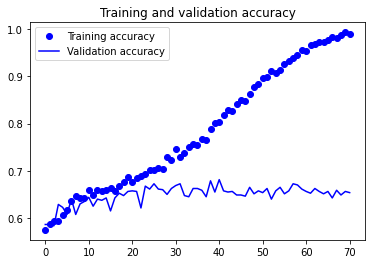

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_0_a.png'))
plt_a.show()

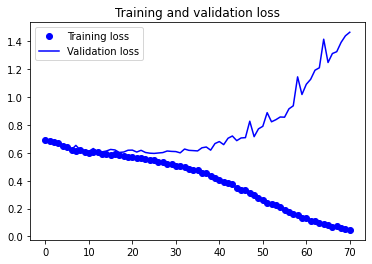

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_0_b.png'))
plt_b.show()

In [ ]:
test_loss, test_acc = model_0.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.7171 - acc: 0.6594
0.659375011920929


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.72      0.76      0.74       219
         1.0       0.50      0.45      0.48       117

    accuracy                           0.65       336
   macro avg       0.61      0.61      0.61       336
weighted avg       0.65      0.65      0.65       336



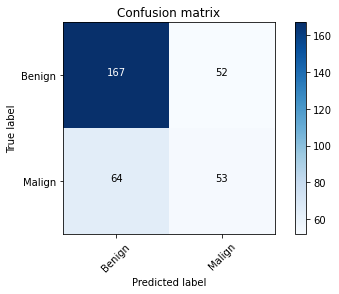

In [ ]:
#print confusion matrix
classes = ["Benign", "Malign"]
#model_0.load_weights(checkpoint_filepath)
plt_0 = plot_confusion_matrix(model_0,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_CM.png'))

In [ ]:
plt_0.clf()
plt_0.close()

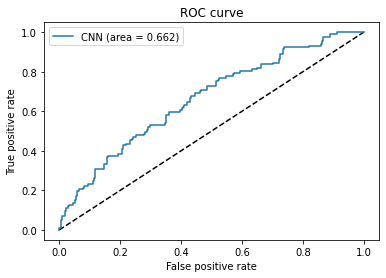

In [ ]:
#ROC-AUC 
auc_0, plt_0 = plot_AUC(model_0, test_images, test_labels)
AUC_values.append(auc_0)

#save & show plot
plt_0.savefig(os.path.join(PLOTS_PATH, 'model_0_AUC.png'))
plt_0.show()

In [ ]:
predictions = get_model_pred_prob(model_0, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  53
FP:  52
TN:  167
FN:  64

TPR(Recall): 		 0.453
FPR: 			 0.2374

Precision: 		 0.5048
TNR(Specificity): 	 0.7626


##6.Dealing with imbalanced dataset: 

### CNN Model No.1 Weighted Class Approah

In [ ]:
from sklearn.utils import class_weight

#compute class_weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels_split),
                                                 train_labels_split)

class_weights = {0: class_weights[0],
                 1: class_weights[1]}

print(class_weights)

{0: 0.8583868010999084, 1: 1.1975703324808185}


In [ ]:
model_1 = build_model("binary_crossentropy", "acc")

#model.summary()

history = model_1.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=class_weights,
                    callbacks=[model_checkpoint_callback, es])


Epoch 1/100
93/93 [==============================] - 3s 21ms/step - loss: 0.6978 - acc: 0.5130 - val_loss: 0.6980 - val_acc: 0.4162
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6899 - acc: 0.4927 - val_loss: 0.7331 - val_acc: 0.4175
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6814 - acc: 0.5355 - val_loss: 0.6845 - val_acc: 0.5512
Epoch 4/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6570 - acc: 0.5849 - val_loss: 0.6951 - val_acc: 0.5500
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6414 - acc: 0.6027 - val_loss: 0.6538 - val_acc: 0.5962
Epoch 6/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6361 - acc: 0.6050 - val_loss: 0.6409 - val_acc: 0.6275
Epoch 7/100
93/93 [==============================] - 2s 19ms/step - loss: 0.6332 - acc: 0.6144 - val_loss: 0.6489 - val_acc: 0.5825
Epoch 8/100
93/93 [==============================] - 2s 19ms/step - loss: 0.

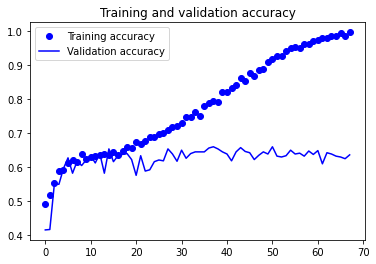

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_1_a.png'))
plt_a.show()

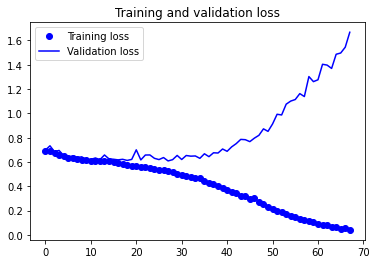

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_1_b.png'))
plt_b.show()

In [ ]:
test_loss, test_acc = model_1.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.7321 - acc: 0.6094
0.609375


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.72      0.64      0.68       219
         1.0       0.45      0.54      0.49       117

    accuracy                           0.61       336
   macro avg       0.58      0.59      0.58       336
weighted avg       0.63      0.61      0.61       336



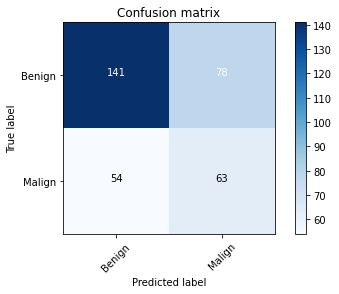

In [ ]:
#model_1.load_weights(checkpoint_filepath)
plt_1 = plot_confusion_matrix(model_1,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_CM.png'))

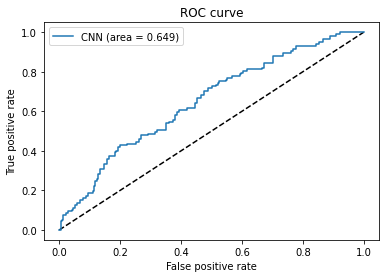

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model_1, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model_1, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  63
FP:  78
TN:  141
FN:  54

TPR(Recall): 		 0.5385
FPR: 			 0.3562

Precision: 		 0.4468
TNR(Specificity): 	 0.6438


### CNN Model No.1.1 Weighted Class Approah

In [ ]:
from sklearn.utils import class_weight

#compute class_weights
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(train_labels_split),
                                                 train_labels_split)

class_weights = {0: 0.30,
                 1: 0.70}

print(class_weights)

{0: 0.3, 1: 0.7}


In [ ]:
model_1 = build_model("binary_crossentropy", "acc")

#model.summary()

history = model_1.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    class_weight=class_weights,
                    callbacks=[model_checkpoint_callback, es])


Epoch 1/100
93/93 [==============================] - 10s 25ms/step - loss: 0.3046 - acc: 0.3985 - val_loss: 0.8372 - val_acc: 0.4062
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3016 - acc: 0.4266 - val_loss: 0.7356 - val_acc: 0.4137
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2983 - acc: 0.4335 - val_loss: 0.8590 - val_acc: 0.4150
Epoch 4/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2940 - acc: 0.4658 - val_loss: 0.7532 - val_acc: 0.4825
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2817 - acc: 0.5234 - val_loss: 0.8098 - val_acc: 0.4913
Epoch 6/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2749 - acc: 0.5742 - val_loss: 0.6883 - val_acc: 0.5350
Epoch 7/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2752 - acc: 0.5649 - val_loss: 0.7176 - val_acc: 0.5412
Epoch 8/100
93/93 [==============================] - 2s 19ms/step - loss: 0

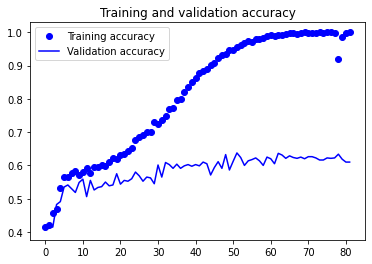

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_1_a.png'))
plt_a.show()

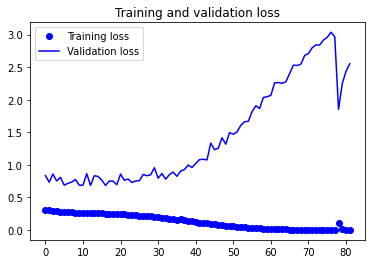

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_1_b.png'))
plt_b.show()

In [ ]:
test_loss, test_acc = model_1.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 8ms/step - loss: 1.5465 - acc: 0.5844
0.5843750238418579


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.71      0.62      0.66       219
         1.0       0.42      0.52      0.47       117

    accuracy                           0.59       336
   macro avg       0.57      0.57      0.56       336
weighted avg       0.61      0.59      0.59       336



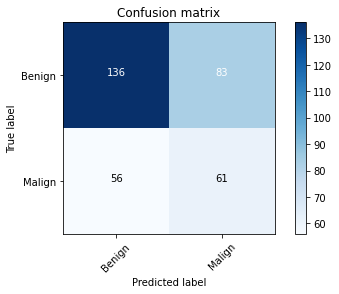

In [ ]:
#model_1.load_weights(checkpoint_filepath)
classes = ["Benign", "Malign"]
plt_1 = plot_confusion_matrix(model_1,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_CM.png'))

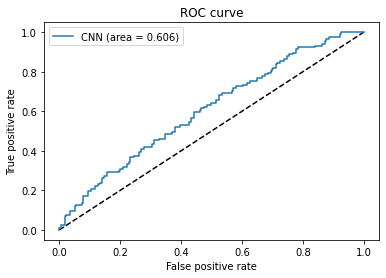

In [ ]:
#ROC-AUC 
auc_1, plt_1 = plot_AUC(model_1, test_images, test_labels)
AUC_values.append(auc_1)

#save & show plot
plt_1.savefig(os.path.join(PLOTS_PATH, 'model_1_AUC.png'))
plt_1.show()

In [ ]:
predictions = get_model_pred_prob(model_1, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  61
FP:  83
TN:  136
FN:  56

TPR(Recall): 		 0.5214
FPR: 			 0.379

Precision: 		 0.4236
TNR(Specificity): 	 0.621


### CNN Model No.2 Undersampling Majority Class: 
picking up same number of samples of data for both majority and minority classes.

![img](https://i1.wp.com/dataaspirant.com/wp-content/uploads/2020/08/17-undersampling.png?resize=768%2C399&ssl=1)

In [ ]:
#undersampling
def undersample(dataset, labels):
  unique, counts = np.unique(labels, return_counts=True)
  #print("Benign samples: ", counts[0])
  #print("Malign samples: ", counts[1])

  num_elems = np.min(counts)
  zipped = list(zip(dataset, labels))

  undersampled_images = np.zeros((num_elems*2,) +  dataset[0].shape) #(num_elems, 150, 150, 1)
  undersampled_labels = np.zeros((num_elems*2,))                     #(num_elems*2, )
  #print(undersampled_beign_class.shape)

  i = 0
  benign_counts = 0
  for image, label in zipped:
    if label == 0 and benign_counts < num_elems:
      undersampled_images[i] = image 
      undersampled_labels[i] = label 
      benign_counts += 1
      i += 1 

    elif label == 1:
      undersampled_images[i] = image 
      undersampled_labels[i] = label 
      i += 1 

    if i == num_elems*2:
      break

  return undersampled_images, undersampled_labels

In [ ]:
undersampled_images, undersampled_labels = undersample(train_images, train_labels)

unique, counts = np.unique(undersampled_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])

Benign samples:  1108
Malign samples:  1108


In [ ]:
# split dataset into training and validation set 70-30
us_train_images_split, us_valid_images_split, us_train_labels_split, us_valid_labels_split = split_train_val(undersampled_images, undersampled_labels)  

(1551, 150, 150, 1)
(665, 150, 150, 1)
(1551,)
(665,)


In [ ]:
model_2 = build_model("binary_crossentropy", "acc")

#model_2.summary()

history = model_2.fit(train_datagen.flow(us_train_images_split,
                                       us_train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(us_train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(us_valid_images_split,
                                       us_valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(us_valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
77/77 [==============================] - 2s 21ms/step - loss: 0.6902 - acc: 0.5851 - val_loss: 0.7947 - val_acc: 0.3076
Epoch 2/100
77/77 [==============================] - 1s 19ms/step - loss: 0.6914 - acc: 0.5558 - val_loss: 0.7923 - val_acc: 0.3076
Epoch 3/100
77/77 [==============================] - 1s 19ms/step - loss: 0.6781 - acc: 0.5948 - val_loss: 0.6892 - val_acc: 0.4909
Epoch 4/100
77/77 [==============================] - 1s 19ms/step - loss: 0.6720 - acc: 0.5811 - val_loss: 0.7180 - val_acc: 0.3621
Epoch 5/100
77/77 [==============================] - 1s 19ms/step - loss: 0.6452 - acc: 0.6172 - val_loss: 0.7307 - val_acc: 0.4591
Epoch 6/100
77/77 [==============================] - 1s 19ms/step - loss: 0.6393 - acc: 0.6225 - val_loss: 0.7523 - val_acc: 0.4758
Epoch 7/100
77/77 [==============================] - 1s 19ms/step - loss: 0.6232 - acc: 0.6493 - val_loss: 0.7048 - val_acc: 0.4636
Epoch 8/100
77/77 [==============================] - 1s 19ms/step - loss: 0.

In [ ]:
test_loss, test_acc = model_2.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.6715 - acc: 0.5594
0.559374988079071


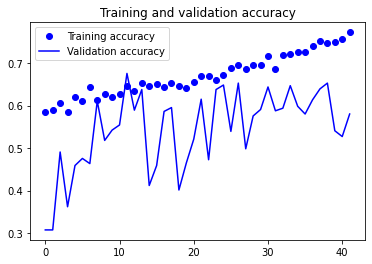

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_2_a.png'))
plt_a.show()

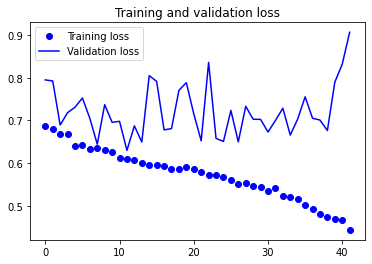

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_2_b.png'))
plt_b.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.78      0.43      0.55       219
         1.0       0.42      0.78      0.55       117

    accuracy                           0.55       336
   macro avg       0.60      0.60      0.55       336
weighted avg       0.66      0.55      0.55       336



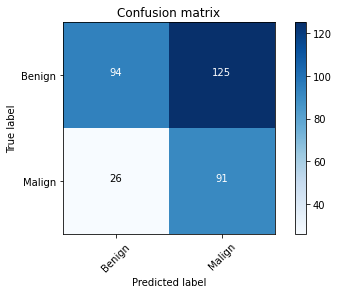

In [ ]:
#model_2.load_weights(checkpoint_filepath)
plt_2 = plot_confusion_matrix(model_2,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_2.savefig(os.path.join(PLOTS_PATH, 'model_2_CM.png'))

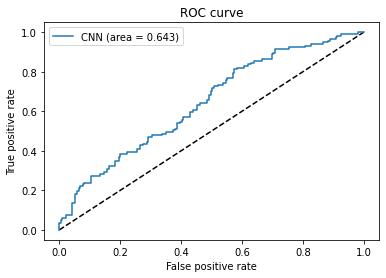

In [ ]:
#ROC-AUC 
auc_2, plt_2 = plot_AUC(model_2, test_images, test_labels)
AUC_values.append(auc_2)

#save plot
plt_2.savefig(os.path.join(PLOTS_PATH, 'model_2_AUC.png'))
plt_2.show()

In [ ]:
predictions = get_model_pred_prob(model_2, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  91
FP:  125
TN:  94
FN:  26

TPR(Recall): 		 0.7778
FPR: 			 0.5708

Precision: 		 0.4213
TNR(Specificity): 	 0.4292


### CNN Model No.3 Data augmentation.

In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

print("Done")

Done


In [ ]:
model_3 = build_model("binary_crossentropy", "acc")

#model_3.summary()

history = model_3.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
93/93 [==============================] - 4s 42ms/step - loss: 0.6900 - acc: 0.5640 - val_loss: 0.6832 - val_acc: 0.5863
Epoch 2/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6896 - acc: 0.5583 - val_loss: 0.6814 - val_acc: 0.5863
Epoch 3/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6841 - acc: 0.5832 - val_loss: 0.6875 - val_acc: 0.5863
Epoch 4/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6779 - acc: 0.5889 - val_loss: 0.6713 - val_acc: 0.6162
Epoch 5/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6643 - acc: 0.5713 - val_loss: 0.6542 - val_acc: 0.6037
Epoch 6/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6632 - acc: 0.5965 - val_loss: 0.6471 - val_acc: 0.6400
Epoch 7/100
93/93 [==============================] - 4s 40ms/step - loss: 0.6385 - acc: 0.6431 - val_loss: 0.6598 - val_acc: 0.6062
Epoch 8/100
93/93 [==============================] - 4s 41ms/step - loss: 0.

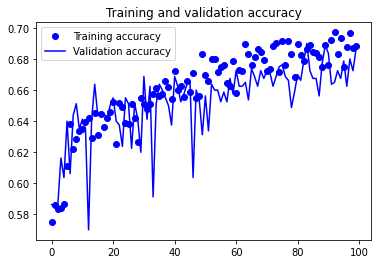

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_3_a.png'))
plt_a.show()

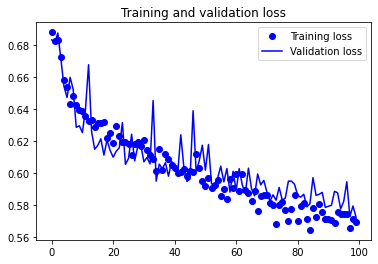

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_3_b.png'))
plt_b.show()

In [ ]:
test_loss, test_acc = model_3.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.5935 - acc: 0.6844
0.684374988079071


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.77      0.72      0.75       219
         1.0       0.54      0.61      0.57       117

    accuracy                           0.68       336
   macro avg       0.66      0.66      0.66       336
weighted avg       0.69      0.68      0.69       336



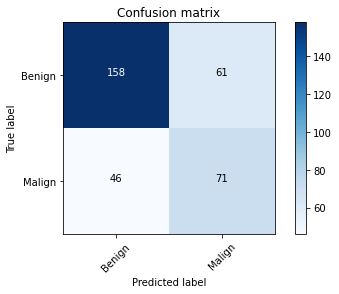

In [ ]:
#model_3.load_weights(checkpoint_filepath)
plt_3 = plot_confusion_matrix(model_3,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_3.savefig(os.path.join(PLOTS_PATH, 'model_3_CM.png'))

In [ ]:
plt_3.clf()
plt_3.close()

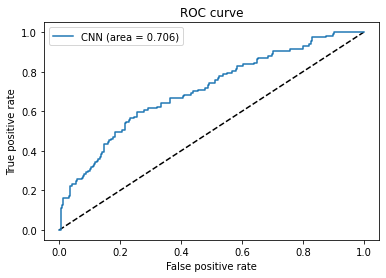

In [ ]:
#ROC-AUC 
auc_3, plt_3 = plot_AUC(model_3, test_images, test_labels)
AUC_values.append(auc_3)

#save plot
plt_3.savefig(os.path.join(PLOTS_PATH, 'model_3_AUC.png'))
plt_3.show()

In [ ]:
predictions = get_model_pred_prob(model_3, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  71
FP:  61
TN:  158
FN:  46

TPR(Recall): 		 0.6068
FPR: 			 0.2785

Precision: 		 0.5379
TNR(Specificity): 	 0.7215


### CNN Model No.4 Undersampling + data augmentation.

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = init_data()

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done


In [ ]:
undersampled_images, undersampled_labels = undersample(train_images, train_labels)

unique, counts = np.unique(undersampled_labels, return_counts=True)
print("Benign samples: ", counts[0])
print("Malign samples: ", counts[1])

Benign samples:  1108
Malign samples:  1108


In [ ]:
# split dataset into training and validation set 70-30
us_train_images_split, us_valid_images_split, us_train_labels_split, us_valid_labels_split = split_train_val(undersampled_images, undersampled_labels)  

(1551, 150, 150, 1)
(665, 150, 150, 1)
(1551,)
(665,)


In [ ]:
model_4 = build_model("binary_crossentropy", "acc")

#model_4.summary()

history = model_4.fit(train_datagen.flow(us_train_images_split,
                                       us_train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(us_train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(us_valid_images_split,
                                       us_valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(us_valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
77/77 [==============================] - 4s 44ms/step - loss: 0.6921 - acc: 0.6077 - val_loss: 0.7238 - val_acc: 0.3076
Epoch 2/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6862 - acc: 0.5845 - val_loss: 0.7861 - val_acc: 0.3076
Epoch 3/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6889 - acc: 0.5797 - val_loss: 0.9105 - val_acc: 0.3076
Epoch 4/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6767 - acc: 0.5860 - val_loss: 0.7245 - val_acc: 0.5030
Epoch 5/100
77/77 [==============================] - 3s 40ms/step - loss: 0.6509 - acc: 0.6151 - val_loss: 0.7209 - val_acc: 0.3636
Epoch 6/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6642 - acc: 0.5842 - val_loss: 0.8275 - val_acc: 0.4212
Epoch 7/100
77/77 [==============================] - 3s 41ms/step - loss: 0.6585 - acc: 0.6181 - val_loss: 0.7379 - val_acc: 0.4379
Epoch 8/100
77/77 [==============================] - 3s 42ms/step - loss: 0.

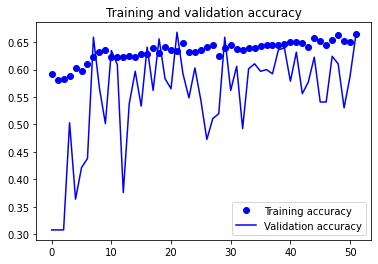

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_4_a.png'))
plt_a.show()

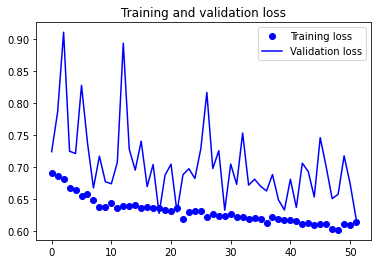

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_4_b.png'))
plt_b.show()

In [ ]:
test_loss, test_acc = model_4.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.6736 - acc: 0.5562
0.5562499761581421


Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.76      0.46      0.57       219
         1.0       0.42      0.73      0.53       117

    accuracy                           0.55       336
   macro avg       0.59      0.59      0.55       336
weighted avg       0.64      0.55      0.56       336



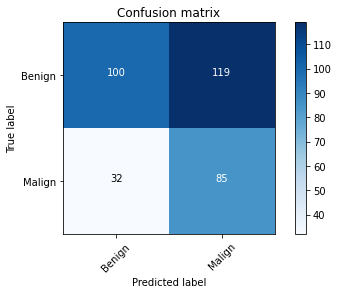

In [ ]:
#model_4.load_weights(checkpoint_filepath)
plt_4 = plot_confusion_matrix(model_4,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_4.savefig(os.path.join(PLOTS_PATH, 'model_4_CM.png'))

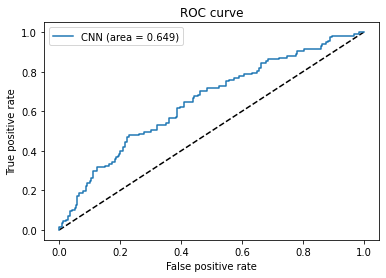

In [ ]:
#ROC-AUC 
auc_4, plt_4 = plot_AUC(model_4, test_images, test_labels)
AUC_values.append(auc_4)

#save plot
plt_4.savefig(os.path.join(PLOTS_PATH, 'model_4_AUC.png'))
plt_4.show()

In [ ]:
predictions = get_model_pred_prob(model_4, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  85
FP:  119
TN:  100
FN:  32

TPR(Recall): 		 0.7265
FPR: 			 0.5434

Precision: 		 0.4167
TNR(Specificity): 	 0.4566


### CNN Model No.5 Oversampling + data augmentation.

![img](https://i0.wp.com/dataaspirant.com/wp-content/uploads/2020/08/10-oversampling.png?resize=768%2C407&ssl=1)

In [ ]:
#oversampling
def oversample(dataset, labels):
  unique, counts = np.unique(labels, return_counts=True)

  num_elems = np.max(counts) - np.min(counts)  
  zipped = list(zip(dataset, labels))

  oversampled_images = np.zeros((np.max(counts)*2,) +  dataset[0].shape) #(np.max(counts)*2, 150, 150, 1)
  oversampled_labels = np.zeros((np.max(counts)*2,))                     #(np.max(counts)*2, )

  #Benign samples:  1568
  #Malign samples:  1108

  i = 0
  benign_count = 0
  malign_count = 0
  malign_indexes = []
  for image, label in zipped:
    if label == 0 and benign_count < 1568:
      oversampled_images[i] = image 
      oversampled_labels[i] = label 
      benign_count += 1
      i += 1

    elif label == 1 and malign_count < 1108:
      oversampled_images[i] = image 
      oversampled_labels[i] = label 
      malign_count += 1
      malign_indexes.append(i)
      i += 1

    if malign_count == 1108:
      #generate array with [num_elems] random values in range [0, len(malign_indexes)]
      rands = np.random.randint(0, len(malign_indexes), num_elems)

      for value in rands:
        oversampled_images[i] = oversampled_images[value]
        oversampled_labels[i] = 1 
        i += 1
      break

  #print(oversampled_images.shape)
  #print(oversampled_labels.shape)

  return oversampled_images, oversampled_labels
  

oversampled_images, oversampled_labels = oversample(train_images, train_labels)

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = init_data()

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done


In [ ]:
unique, counts = np.unique(oversampled_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1568 1568]


In [ ]:
# split dataset into training and validation set 70-30
train_images_split, valid_images_split, train_labels_split, valid_labels_split = split_train_val(oversampled_images, oversampled_labels)  

(2195, 150, 150, 1)
(941, 150, 150, 1)
(2195,)
(941,)


In [ ]:
model_5 = build_model("binary_crossentropy", "acc")

#model_5.summary()

history = model_5.fit(train_datagen.flow(train_images_split,
                                       train_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
109/109 [==============================] - 5s 42ms/step - loss: 0.6862 - acc: 0.5752 - val_loss: 0.7448 - val_acc: 0.2947
Epoch 2/100
109/109 [==============================] - 4s 40ms/step - loss: 0.6871 - acc: 0.5688 - val_loss: 0.7836 - val_acc: 0.2947
Epoch 3/100
109/109 [==============================] - 4s 40ms/step - loss: 0.6761 - acc: 0.5857 - val_loss: 0.7027 - val_acc: 0.3766
Epoch 4/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6675 - acc: 0.6017 - val_loss: 0.7317 - val_acc: 0.4362
Epoch 5/100
109/109 [==============================] - 5s 41ms/step - loss: 0.6347 - acc: 0.6490 - val_loss: 0.6750 - val_acc: 0.6064
Epoch 6/100
109/109 [==============================] - 4s 40ms/step - loss: 0.6608 - acc: 0.6125 - val_loss: 0.7279 - val_acc: 0.4862
Epoch 7/100
109/109 [==============================] - 4s 41ms/step - loss: 0.6530 - acc: 0.6063 - val_loss: 0.8935 - val_acc: 0.3479
Epoch 8/100
109/109 [==============================] - 4s 40ms

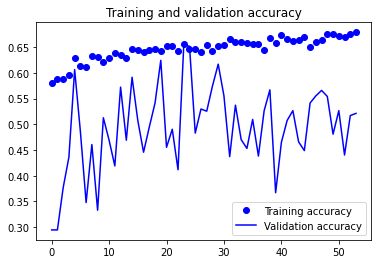

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_5_a.png'))
plt_a.show()

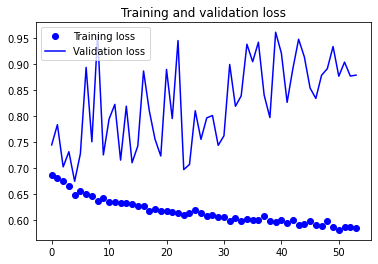

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_5_b.png'))
plt_b.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.84      0.33      0.48       219
         1.0       0.41      0.88      0.56       117

    accuracy                           0.52       336
   macro avg       0.63      0.61      0.52       336
weighted avg       0.69      0.52      0.51       336



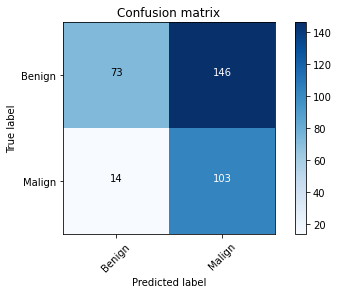

In [ ]:
#model_5.load_weights(checkpoint_filepath)
plt_5 = plot_confusion_matrix(model_5,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_5.savefig(os.path.join(PLOTS_PATH, 'model_5_CM.png'))

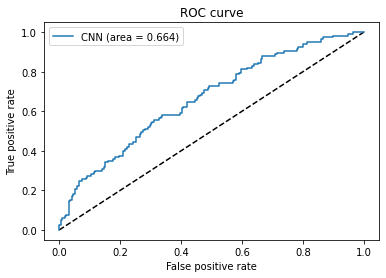

In [ ]:
#ROC-AUC 
auc_5, plt_5 = plot_AUC(model_5, test_images, test_labels)
AUC_values.append(auc_5)

#save plot
plt_5.savefig(os.path.join(PLOTS_PATH, 'model_5_AUC.png'))
plt_5.show()

In [ ]:
predictions = get_model_pred_prob(model_5, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  103
FP:  146
TN:  73
FN:  14

TPR(Recall): 		 0.8803
FPR: 			 0.6667

Precision: 		 0.4137
TNR(Specificity): 	 0.3333


### CNN Model No.6 Minority Class Oversampling through data augmentation.

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = init_data()

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done


In [ ]:
unique, counts = np.unique(train_labels_split, return_counts=True)
print(unique, counts)

[0. 1.] [1080  793]


In [ ]:
# Need Train data augmentation without rescaling (rescale all data before training) 
train_datagen = ImageDataGenerator(
    #rescale=1./65535,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
#minority class oversampling through data augmentation
def oversample_augmentation(dataset, labels, scale_factor_m, scale_factor_b):
  unique, counts = np.unique(labels, return_counts=True)
  num_benign = counts[0]
  num_malign = counts[1]

  zipped = list(zip(dataset, labels))

  benign_images = np.zeros((num_benign,) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  benign_labels = np.zeros((num_benign,))                       #(num_benign, )
  malign_images = np.zeros((num_malign,) +  dataset[0].shape)   #(num_malign, 150, 150, 1)
  malign_labels = np.zeros((num_malign,))                       #(num_malign, )

  #Benign samples:  1568
  #Malign samples:  1108

  benign_idx = 0
  malign_idx = 0
  for image, label in zipped:
    #get benign samples only
    if label == 0:
      benign_images[benign_idx] = image 
      benign_labels[benign_idx] = label 
      benign_idx += 1
    #get malign samples only
    elif label == 1:
      malign_images[malign_idx] = image 
      malign_labels[malign_idx] = label 
      malign_idx += 1

  #malign class oversampling through data augmentation
  malign_images_aug = np.zeros((int(num_benign*scale_factor_m),) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  malign_labels_aug = np.zeros((int(num_benign*scale_factor_m),))                       #(num_malign, )
 
  BATCH_size = 1
  i = 0
  for batch, labels_batch in train_datagen.flow(malign_images, malign_labels, batch_size=BATCH_size):
    malign_images_aug[i * BATCH_size : (i + 1) * BATCH_size] = batch
    malign_labels_aug[i * BATCH_size : (i + 1) * BATCH_size] = labels_batch
    i += 1

    if i * BATCH_size  >= int(num_benign*scale_factor_m):
      break
  
  #benign class oversampling through data augmentation
  benign_images_aug = np.zeros((int(num_benign*scale_factor_b),) +  dataset[0].shape)   #(num_benign, 150, 150, 1)
  benign_labels_aug = np.zeros((int(num_benign*scale_factor_b),))                       #(num_malign, )
 
  BATCH_size = 1
  i = 0
  for batch, labels_batch in train_datagen.flow(benign_images, benign_labels, batch_size=BATCH_size):
    benign_images_aug[i * BATCH_size : (i + 1) * BATCH_size] = batch
    benign_labels_aug[i * BATCH_size : (i + 1) * BATCH_size] = labels_batch
    i += 1

    if i * BATCH_size  >= int(num_benign*scale_factor_b):
      break
  
  #merge classes back
  train = np.concatenate((malign_images_aug, benign_images_aug), axis=0)
  labels = np.concatenate((malign_labels_aug, benign_labels_aug), axis=0)
  
  #print(malign_images_aug.shape)
  #print(malign_labels_aug.shape)
  #print(benign_images.shape)
  #print(benign_labels.shape)

  #shuffle data
  train, labels = shuffle_dataset(train, labels)

  return train, labels

In [ ]:
scale_factor_m = 1.35       # malign_samples/benign_samples ratio
scale_factor_b = 1.1
os_train_images, os_train_labels = oversample_augmentation(train_images_split, train_labels_split, scale_factor_m, scale_factor_b)

print(os_train_images.shape)
print(os_train_labels.shape)

(2646, 150, 150, 1)
(2646,)


In [ ]:
unique, counts = np.unique(os_train_labels, return_counts=True)
print(unique, counts)

[0. 1.] [1188 1458]


In [ ]:
model_6 = build_model("binary_crossentropy", METRICS)

model_6.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

In [ ]:
history = model_6.fit(train_datagen.flow(os_train_images,
                                       os_train_labels,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=200,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/200
93/93 [==============================] - 11s 43ms/step - loss: 0.6902 - acc: 0.5359 - val_loss: 0.6995 - val_acc: 0.3963
Epoch 2/200
93/93 [==============================] - 4s 42ms/step - loss: 0.6832 - acc: 0.5595 - val_loss: 0.7285 - val_acc: 0.3975
Epoch 3/200
93/93 [==============================] - 4s 42ms/step - loss: 0.6803 - acc: 0.5515 - val_loss: 0.7553 - val_acc: 0.3938
Epoch 4/200
93/93 [==============================] - 4s 43ms/step - loss: 0.6841 - acc: 0.5458 - val_loss: 0.7615 - val_acc: 0.4075
Epoch 5/200
93/93 [==============================] - 4s 41ms/step - loss: 0.6815 - acc: 0.5518 - val_loss: 0.7293 - val_acc: 0.4437
Epoch 6/200
93/93 [==============================] - 4s 41ms/step - loss: 0.6671 - acc: 0.5774 - val_loss: 0.7673 - val_acc: 0.4538
Epoch 7/200
93/93 [==============================] - 4s 41ms/step - loss: 0.6641 - acc: 0.6063 - val_loss: 0.7273 - val_acc: 0.4762
Epoch 8/200
93/93 [==============================] - 4s 41ms/step - loss: 0

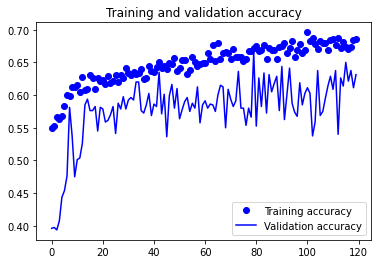

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_6_a.png'))
plt_a.show()

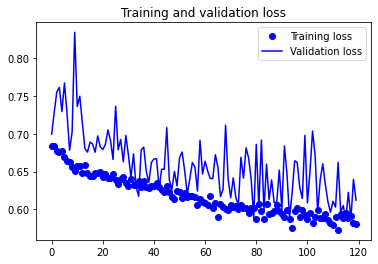

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_6_b.png'))
plt_b.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.77      0.57      0.65       219
         1.0       0.46      0.68      0.55       117

    accuracy                           0.61       336
   macro avg       0.61      0.62      0.60       336
weighted avg       0.66      0.61      0.62       336



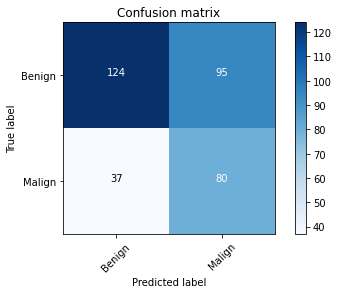

In [ ]:
#model_6.load_weights(checkpoint_filepath)
classes = ["Benign", "Malign"]
plt_6 = plot_confusion_matrix(model_6,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix')  

#save plot
plt_6.savefig(os.path.join(PLOTS_PATH, 'model_6_CM.png'))

In [ ]:
test_loss, test_acc = model_6.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 6ms/step - loss: 0.6437 - acc: 0.6156
0.6156250238418579


In [ ]:
predictions = get_model_pred_prob(model_6, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  80
FP:  95
TN:  124
FN:  37

TPR(Recall): 		 0.6838
FPR: 			 0.4338

Precision: 		 0.4571
TNR(Specificity): 	 0.5662


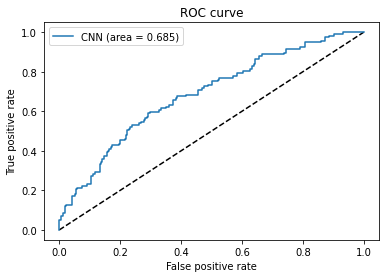

In [ ]:
#ROC-curve
auc_6, plt_6 = plot_AUC(model_6, test_images, test_labels)
AUC_values.append(auc_6)

#save plot
plt_6.savefig(os.path.join(PLOTS_PATH, 'model_6_AUC.png'))
plt_6.show()

### CNN Model No.7 SMOTE: Synthetic Minority Oversampling Technique

In [ ]:
train_images_split, valid_images_split, train_labels_split, valid_labels_split = init_data()

(1873, 150, 150, 1)
(803, 150, 150, 1)
(1873,)
(803,)
Done


In [ ]:
#reshape tensors for SMOTE: (num_samples, 150*150*1)
shape = (len(train_images_split), 150*150)
train_images_SMOTE = train_images_split.reshape(shape) 
print(train_images_SMOTE.shape)
print(train_labels_split.shape)

(1873, 22500)
(1873,)


In [ ]:
#SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE # doctest: +NORMALIZE_WHITESPACE

counter = Counter(train_labels_split)
print('Original dataset shape %s' % counter)
"""
# define pipeline

# use random undersampling to reduce the number 
# of examples in the majority class to have 50 percent 
# more than the minority class 
under = RandomUnderSampler(sampling_strategy=1, replacement=True)


# oversampling minority class in such a way that 
# it has 0.9*num_samples_majority_class samples 
over = SMOTE(sampling_strategy=0.93, n_jobs=-1)

steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X_res, y_res = pipeline.fit_resample(train_images_SMOTE, train_labels_split)
counter = Counter(y_res)
print('Resampled dataset shape %s' % counter)
"""


sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(train_images_SMOTE, train_labels_split)
counter = Counter(y_res)
print('Resampled dataset shape %s' % counter)



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Original dataset shape Counter({0.0: 1091, 1.0: 782})
Resampled dataset shape Counter({1.0: 1091, 0.0: 1091})


In [ ]:
#reshape back tensors for model fitting
shape = (len(X_res), 150, 150, 1)
train_images_SMOTE = X_res.reshape(shape) 

print(train_images_SMOTE.shape)
print(y_res.shape)

(2182, 150, 150, 1)
(2182,)


In [ ]:
# Need Train data augmentation without rescaling (rescale all data before training) 
train_datagen = ImageDataGenerator(
    #rescale=1./65535,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

In [ ]:
scale_factor_b = 1        # malign_samples/benign_samples ratio
scale_factor_m = 1.7
train_images_SMOTE, y_res = oversample_augmentation(train_images_SMOTE, y_res, scale_factor_m, scale_factor_b)

print(train_images_SMOTE.shape)
print(y_res.shape)

(2945, 150, 150, 1)
(2945,)


In [ ]:
# Train data augmentation 
train_datagen = ImageDataGenerator(
    rescale=1./65535,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

valid_datagen = ImageDataGenerator(rescale=1./65535)
test_datagen = ImageDataGenerator(rescale=1./65535) 

In [ ]:
model_7 = build_model("binary_crossentropy", "acc")

model_7.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_40 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 15, 15, 128)     

In [ ]:
history = model_7.fit(train_datagen.flow(train_images_SMOTE,
                                       y_res,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    steps_per_epoch=len(train_images_split) // BATCH_SIZE, 
                    epochs=100,
                    validation_data=valid_datagen.flow(valid_images_split,
                                       valid_labels_split,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False),
                    validation_steps=len(valid_labels_split) // BATCH_SIZE,
                    callbacks=[model_checkpoint_callback, es])

Epoch 1/100
93/93 [==============================] - 5s 45ms/step - loss: 0.6530 - acc: 0.6233 - val_loss: 0.7414 - val_acc: 0.4062
Epoch 2/100
93/93 [==============================] - 4s 41ms/step - loss: 0.6103 - acc: 0.6214 - val_loss: 0.7860 - val_acc: 0.4062
Epoch 3/100
93/93 [==============================] - 4s 40ms/step - loss: 0.5984 - acc: 0.6253 - val_loss: 0.7618 - val_acc: 0.4062
Epoch 4/100
93/93 [==============================] - 4s 40ms/step - loss: 0.5845 - acc: 0.6484 - val_loss: 0.7155 - val_acc: 0.4100
Epoch 5/100
93/93 [==============================] - 4s 40ms/step - loss: 0.5881 - acc: 0.6286 - val_loss: 0.8193 - val_acc: 0.4162
Epoch 6/100
93/93 [==============================] - 4s 41ms/step - loss: 0.5976 - acc: 0.6340 - val_loss: 0.6961 - val_acc: 0.4712
Epoch 7/100
93/93 [==============================] - 4s 41ms/step - loss: 0.5738 - acc: 0.6406 - val_loss: 0.7584 - val_acc: 0.4400
Epoch 8/100
93/93 [==============================] - 4s 41ms/step - loss: 0.

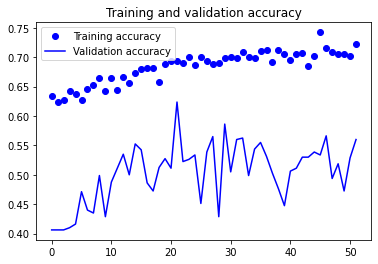

In [ ]:
plt_a = plot_acc(history)
#save & show plot
plt_a.savefig(os.path.join(PLOTS_PATH, 'model_7_a.png'))
plt_a.show()

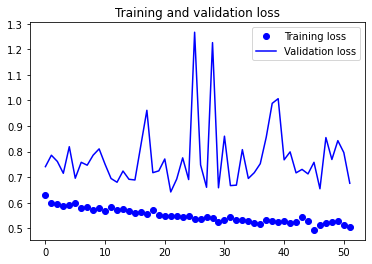

In [ ]:
plt_b = plot_loss(history)
#save & show plot
plt_b.savefig(os.path.join(PLOTS_PATH, 'model_7_b.png'))
plt_b.show()

Confusion Matrix
              precision    recall  f1-score   support

         0.0       0.75      0.50      0.60       219
         1.0       0.42      0.68      0.52       117

    accuracy                           0.56       336
   macro avg       0.58      0.59      0.56       336
weighted avg       0.63      0.56      0.57       336



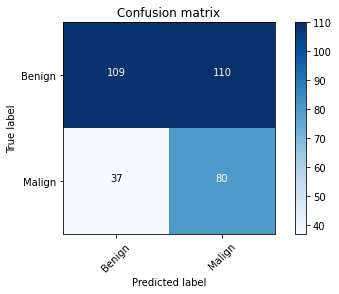

In [ ]:
#model_7.load_weights(checkpoint_filepath)
classes = ["Benign", "Malign"]
plt_7 = plot_confusion_matrix(model_7,
                      classes,
                      test_images,
                      test_labels,
                      title='Confusion matrix',
                      cmap=plt.cm.Blues)  

#save plot
plt_7.savefig(os.path.join(PLOTS_PATH, 'model_7_CM.png'))

In [ ]:
test_loss, test_acc = model_7.evaluate(test_datagen.flow(test_images,
                                                       test_labels,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=False),
                                     steps=len(test_images) // BATCH_SIZE
)

print(test_acc)

16/16 [==============================] - 0s 7ms/step - loss: 0.6914 - acc: 0.5719
0.5718749761581421


In [ ]:
predictions = get_model_pred_prob(model_7, test_images, test_labels, len(test_images))
tpr, fpr, precision, specificity = calc_TP_FP_rate(test_labels, predictions)

print()
print("TPR(Recall): \t\t", round(tpr, 4))
print("FPR: \t\t\t", round(fpr, 4))
print()
print("Precision: \t\t", round(precision, 4))
print("TNR(Specificity): \t", round(specificity, 4))

TPR_values.append(tpr)
FPR_values.append(fpr)
PRECISION_values.append(precision)
SPECIFICITY_values.append(specificity)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


TP:  80
FP:  110
TN:  109
FN:  37

TPR(Recall): 		 0.6838
FPR: 			 0.5023

Precision: 		 0.4211
TNR(Specificity): 	 0.4977


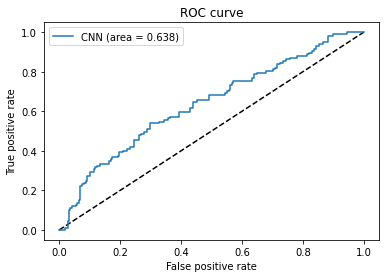

In [ ]:
#ROC-AUC 
auc_7, plt_7 = plot_AUC(model_7, test_images, test_labels)
AUC_values.append(auc_7)

#save plot
plt_7.savefig(os.path.join(PLOTS_PATH, 'model_7_AUC.png'))
plt_7.show()

# Model Results Report

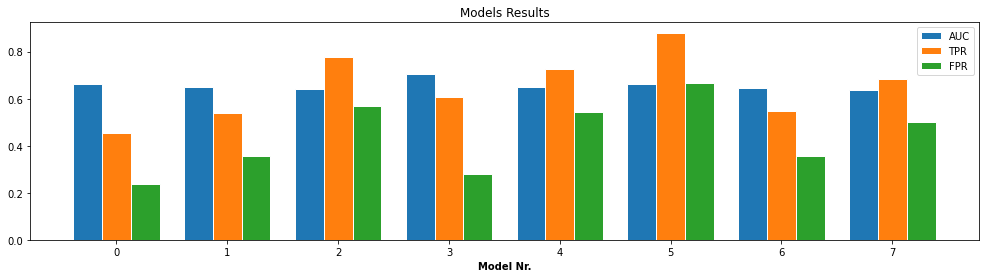

In [ ]:
#AUC_values = np.random.rand(8)
#TPR_values = np.random.rand(8)
#FPR_values = np.random.rand(8)
#PRECISION_values = np.random.rand(8)
#SPECIFICITY_values = np.random.rand(8)

x_labels = ["0", "1", "2", "3", "4", "5", "6", "7"]

# AUC values
counts = AUC_values
bars1 = counts

# TPR values
counts = TPR_values
bars2 = counts

#FPR values
counts = FPR_values
bars3 = counts

# set width of bar
barWidth = 1.3
 
# set height of bar
 
# Set position of bar on X axis
r1 = np.arange(len(bars1))*5
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

fig= plt.figure(figsize=(17,4))

# Make the plot
plt.bar(r1, bars1, width=barWidth, edgecolor='white', label='AUC')
plt.bar(r2, bars2, width=barWidth, edgecolor='white', label='TPR')
plt.bar(r3, bars3, width=barWidth, edgecolor='white', label='FPR')
 
# Add xticks on the middle of the group bars
plt.xlabel('Model Nr.', fontweight='bold')
plt.xticks([r + barWidth for r in r1], x_labels)
#plt.ylabel('Percentages quantity', fontweight='bold')

 
# Create legend & Show graphic
plt.legend()
plt.title('Models Results')

plt.savefig(os.path.join(PLOTS_PATH, "histogram_results.png"))
plt.show()